In [1]:
import matplotlib.pyplot as plt
import numpy as np

### import tainter model

In [2]:
import tainter.model.methods as tm
from tainter.cluster.parameter_setup import generate_parameters
from tainter.cluster.parameter_scan_odeint import parameter_scan
from tainter.f2_plot_stochastic import fig2_stochastic_simulations
from tainter.f3_plot_ensemble_with_approx import fig3_stochastic_ensemble_and_macroscopic_approximation
from tainter.f3b_plot_trajectories import fig3b_administrator_trajectories
from tainter.f4_plot_parameter_analysis import fig4_parameter_analysis


## Threshold, Access and Energy Production

In the initial network, all nodes are uncoordinated workers
$N = N_L$, therefore the total energy production of the initial network is $E=a~N^\psi$, where $\psi$ is the marginal return of investment for uncoordinated workers, since the per capita enegy production is defined as $E_{cap} = \frac{E}{N}$, initially we have $E_{cap,~init} = a~\frac{N^\psi}{N}$. To satisfy $E_{cap,~init} = 1$, resource access ($a$) has to be $a=\frac{N}{N^\psi}$. This can be interpreted as a baseline efficiency of the workers $\geq 1$ to satisfy their needs.

We then assume that the energy in the network is homegenously re-distributed after production and no additional administrator is selected if $E_{cap} \geq 1$

In [3]:
def calculate_initial_energy_production(N, mri_l):
    """
    calculate the amount of per capita energy production at the initial stage
    of the network, when all nodes are uncoordinated workers, if access
    to the resources is equal to 1
    """
    return N ** mri_l / N


def calculate_initial_resource_access(N, mri_l):
    """
    scales the resource access of the network so that it ensures that the initial
    per capita energy production without coordinated workers equals 1.
    """
    return 1 / calculate_initial_energy_production(N, mri_l)

In [6]:
# general parameters
SEED = 651
plot_time = 5000
max_runtime = 10000

# simulation parameters (for all figures)
network="erdos"
network_size = 400
link_probability_between_nodes = 0.02
mri_of_laborers = 0.75
mri_of_coordinated_laborers = 0.75
efficiency_of_coordinated_laborers = 1.05
shock_alpha = 15
shock_beta = 1

first_admin = "highest degree"
choice_next_admin = "topcoordinated"

# figure 2 and 3
exploration_scenarios = [0, 0.00275,  0.02]  # must always be a list of 3

# figure 3
ensemble_data = "../data/ensemble/"
use_pre_simulated_data = True  # uses pre simulated data to generate plot
iterations = 100  # needs to be increased but will take some time

# figure 4
par_scan_output = "../data/parameter_analysis/"



#### play with the simulation

In [ ]:
N_coordinated_workers = 10
t = 0
access = calculate_initial_resource_access(network_size, mri_of_laborers)
A, L, Lc, positions, E_cap, tmax, ainit, A_exp, L_exp, Lc_exp, Admin = tm.init(
    N=network_size, 
    a=access, 
    elast_l=mri_of_laborers, 
    elast_lc=mri_of_coordinated_laborers, 
    eff_lc=efficiency_of_coordinated_laborers,
    tmax=max_runtime
)
G = tm.construct_network(
    network=network, 
    N=network_size, 
    p=link_probability_between_nodes
)

ecap = tm.energy_out_capita(
    a=access, 
    L=L, 
    Lc=Lc, 
    elast_l=mri_of_laborers, 
    elast_lc=mri_of_coordinated_laborers, 
    eff_lc=efficiency_of_coordinated_laborers, 
    N=network_size
)


print(f"Ecap: {round(ecap,2)}")
tm.print_graph(t, A, Lc, L, G, positions, network_size)

#### response to shocks

In [ ]:
network_update = False
while not network_update:
    t += 1
    shock = tm.shock(shock_alpha, shock_beta)
    access_after_shock = access * (1 - shock)

    # ecap after shock
    ecap = tm.energy_out_capita(
        access_after_shock, L, Lc, mri_of_laborers, mri_of_coordinated_laborers, 
        efficiency_of_coordinated_laborers, network_size)

    print(f"time: {t}, Ecap = {round(ecap, 2)} < {1}", end="\r")
    if ecap < 1:
        Admin = tm.select_Admin(G, A, L, Lc, first_admin, choice_next_admin)

        # if no Admin is selected, there is no need to update the network
        if Admin != None:
            L, Lc, A = tm.update_network(A, L, Lc, Admin, G)

        ecap = tm.energy_out_capita(
            access_after_shock, L, Lc, mri_of_laborers, mri_of_coordinated_laborers, 
            efficiency_of_coordinated_laborers, network_size)

        print(f"time: {t}, Ecap after network update: {ecap}")

        tm.print_graph(0, A, Lc, L, G, positions, network_size, layout="fixed")

        network_update = True

## Stochastic Simulation

#### Figure 2 

In [ ]:
f2 = fig2_stochastic_simulations(
    seed=SEED,
    plot_time=plot_time,
    network_size=network_size,
    link_probability_between_nodes=link_probability_between_nodes,
    mri_of_laborers=mri_of_laborers,
    mri_of_coordinated_laborers=mri_of_coordinated_laborers,
    efficiency_of_coordinated_laborers=efficiency_of_coordinated_laborers,
    exploration_setups=exploration_scenarios,
    shock_alpha=shock_alpha,
    shock_beta=shock_beta
)
plt.show()
f2.savefig("pub_figure2.png", dpi = 65)


## Macroscopic Approximation

the macroscopic approximation is

$\frac{dN_A}{dt}=p_e(N-2 N_A) + F(\frac{N ^ \psi}{E}, \beta, \alpha), with$


$E = ((N-N_a)(1-\rho)^{N_a})^\psi + c((N-N_A)(1-(1-\rho)^{N_A}))^\phi$


$E_{cap} =  \frac{E}{N ^ \psi} $

where $F$ is the cumulative Beta distribution and $N^\psi$ is the initial energy production of the network without any coordinated workers. It implies the assumption that resource of the network increases exponentially with decreasing marginal returns. This is done to satisfy that the initial energy production always satistfy $E_{cap} = 1$


#### Figure 3

In [ ]:
f3 = fig3_stochastic_ensemble_and_macroscopic_approximation(
    seed=SEED,
    plot_time=plot_time,
    network_size=network_size,
    link_probability_between_nodes=link_probability_between_nodes,
    mri_of_laborers=mri_of_laborers,
    mri_of_coordinated_laborers=mri_of_coordinated_laborers,
    efficiency_of_coordinated_laborers=efficiency_of_coordinated_laborers,
    exploration_setups=exploration_scenarios,
    shock_alpha=shock_alpha,
    shock_beta=shock_beta,
    ensemble_data=ensemble_data,
    iterations=iterations,
    use_pre_simulated_data=use_pre_simulated_data
)
plt.show()
f3.savefig("pub_figure3.png", dpi = 65)

In [ ]:
mri = 0.35

f3b = fig3b_administrator_trajectories(
    exploration_setups=[0.002, 0.0002],
    network_size=network_size,
    link_probability_between_nodes=0.2,
    mri_of_coordinated_laborers=mri,
    mri_of_laborers=mri,
    efficiency_of_coordinated_laborers=1.5,
    shock_alpha=shock_alpha,
    shock_beta=shock_beta
)

plt.show()
f3b.savefig("pub_figure3b.png", dpi=65)

## Parameter Analysis of Macroscopic Approximation

In [12]:
# select parameter ranges
rho = np.linspace(0, 0.3, 10)  # link density in erdos renyi network
c = np.linspace(1, 3, 20)  # efficiency of coordinated Workers
pe_null = np.array([0])
pe_explore = np.logspace(-5, -1.6, num=9)
p_e = np.concatenate((pe_null, pe_explore), axis=None)

approx_parameters = dict(
    N=400,
    p_e=None,
    rho=None,
    psi=0.75,
    phi=0.75,
    c=None,
    alpha=1,
    beta=15
)


parameters, n_chunks = generate_parameters(
    output=par_scan_output,
    approx_parameters=approx_parameters,
    chunk_size=None,
    p_e=p_e,
    rho=rho,
    c=c,
)

print(f"prepared parameters {parameters} in {n_chunks} chunks.")

0
prepared parameters ['p_e', 'rho', 'c'] in 1 chunks.


In [13]:
# run parameter scan

parameter_scan(
    output_dir=par_scan_output,
    njob=1,
    parameters=parameters,
    # approximation params

)

['p_e', 'rho', 'c'] ../data/parameter_analysis/ 1
{'N': 400, 'p_e': None, 'rho': None, 'psi': 0.75, 'phi': 0.75, 'c': None, 'alpha': 1, 'beta': 15}


100%|██████████| 2000/2000 [03:31<00:00,  9.44it/s]


Import complete
2000 10 10 20


IndexError: index 3 is out of bounds for axis 0 with size 3

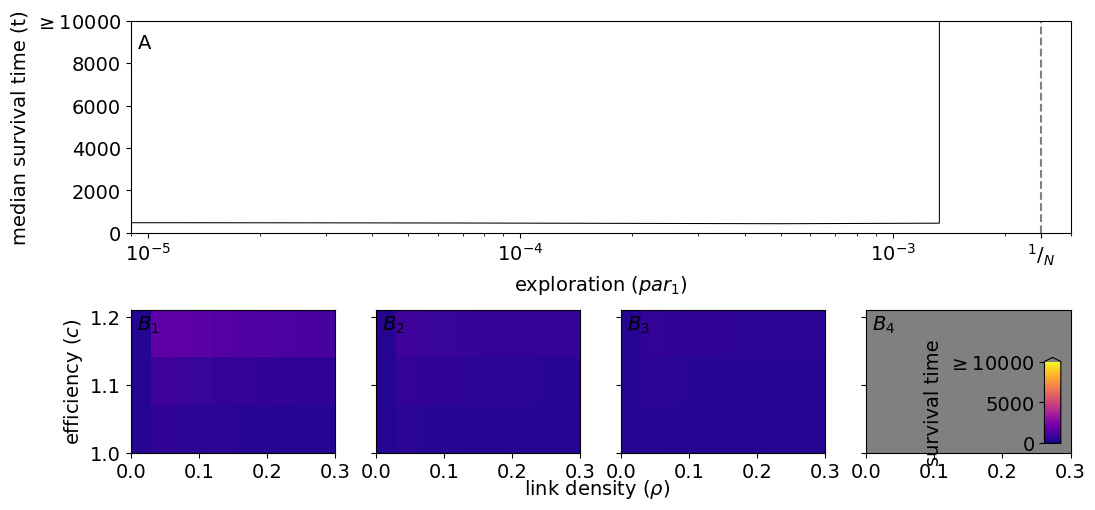

In [17]:
f4 = fig4_parameter_analysis(
    data_directory=par_scan_output,
    parameters=["\\rho", "p_e", "c"],
    panel_steps=[0, 1e-4, 5e-4, 5e-3],
    multiline_steps=[]
)

plt.show()
f4.savefig("pub_figure4.png", dpi=65)